# Survival Analysis Project
## Kaplan–Meier and Cox Proportional Hazards Model

This notebook demonstrates survival analysis using simulated data,
including relapse-free survival (RFS) and progression-free survival (PFS).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter

np.random.seed(42)


In [2]:
!pip install lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=5139d6f1ebf3a1d6f9f1f6f0d92c4adc36433ab50e61476e34a63f3eff6a709e
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [4]:
n = 200

# Covariates
age = np.random.normal(60, 10, n)
treatment = np.random.binomial(1, 0.5, n)

# Baseline hazard
baseline_hazard = 0.01

# Survival time generation
true_time = np.random.exponential(
    scale=1 / (baseline_hazard * np.exp(0.03 * age - 0.5 * treatment))
)

# Censoring
censoring_time = np.random.exponential(50, n)

event = true_time <= censoring_time
time_observed = np.minimum(true_time, censoring_time)

df = pd.DataFrame({
    "time": time_observed,
    "event": event.astype(int),
    "age": age,
    "treatment": treatment
})

df.head()


,time,event,age,treatment
0,5.367150,0,64.967142,1
1,8.294415,0,58.617357,1
2,7.550508,1,66.476885,1
3,8.758244,0,75.230299,1
4,4.487854,1,57.658466,0


## 🧪 Data Preparation and Censoring

At this stage, we construct the final survival dataset by incorporating
**right censoring**, which is a key component of time‑to‑event data.

First, random censoring times are generated from an exponential distribution.
An event indicator is then defined by comparing the true event time with the
censoring time:

- If the true event occurs before the censoring time, the event is observed.
- Otherwise, the observation is right‑censored.

The observed survival time is defined as the minimum of the true event time
and the censoring time.

Finally, a pandas DataFrame is created with the following variables:
- **time**: observed survival time  
- **event**: event indicator (1 = event occurred, 0 = censored)  
- **age**: baseline age of the individual  
- **treatment**: treatment assignment (1 = treatment, 0 = control)

This dataset is now suitable for Kaplan–Meier estimation and Cox proportional
hazards modeling.


In [5]:
df.describe()


,time,event,age,treatment
count,200.000000,200.000000,200.000000,200.000000
mean,16.341925,0.685000,59.592290,0.520000
std,20.527906,0.465682,9.310039,0.500854
min,0.207517,0.000000,33.802549,0.000000
25%,4.256208,0.000000,52.948723,0.000000
50%,9.952166,1.000000,59.958081,1.000000
75%,21.357585,1.000000,65.008525,1.000000
max,159.286531,1.000000,87.201692,1.000000


## 📈 Kaplan–Meier Survival Curves — Interpretation

The Kaplan–Meier curves compare survival probabilities between the **treatment** and **control** groups over time.

Overall, the treatment group shows **higher survival probabilities** across most of the follow‑up period compared to the control group. This indicates that patients receiving treatment tend to experience the event **later** than those in the control group.

The separation between the curves suggests a **beneficial effect of treatment** on survival.  
The shaded areas represent **confidence intervals**, reflecting uncertainty due to censoring and sample size.

These findings are consistent with the Cox proportional hazards model, which also indicates a **protective treatment effect**.


## 📈 Cox Model Coefficients — Interpretation (Math + Explanation)

The Cox proportional hazards model is defined as:

$$
h(t \mid X) = h_0(t)\exp(\beta^\top X)
$$

where \( \beta \) represents the effect of covariates on the hazard.

---

### How the coefficient plot is interpreted

The coefficient plot displays the estimated regression coefficients \( \beta \)
on the **log-hazard scale**.

- Coefficients **to the right of zero**:
  $$
  \beta > 0 \;\Rightarrow\; \exp(\beta) > 1
  $$
  indicating an **increase in hazard**.

- Coefficients **to the left of zero**:
  $$
  \beta < 0 \;\Rightarrow\; \exp(\beta) < 1
  $$
  indicating a **decrease in hazard** (protective effect).

---

### Variable-level interpretation

- **Age**  
  $$
  \beta_{\text{age}} > 0 \;\Rightarrow\; \text{HR}_{\text{age}} = \exp(\beta_{\text{age}}) > 1
  $$
  This means that increasing age is associated with a higher risk of the event.

- **Treatment**  
  $$
  \beta_{\text{treatment}} < 0 \;\Rightarrow\; \text{HR}_{\text{treatment}} = \exp(\beta_{\text{treatment}}) < 1
  $$
  This indicates that treatment reduces the hazard compared to the control group.

---

### Key idea
The **sign of \( \beta \)** determines the direction of the effect, while the
**magnitude of \( |\beta| \)** reflects the strength of the association.


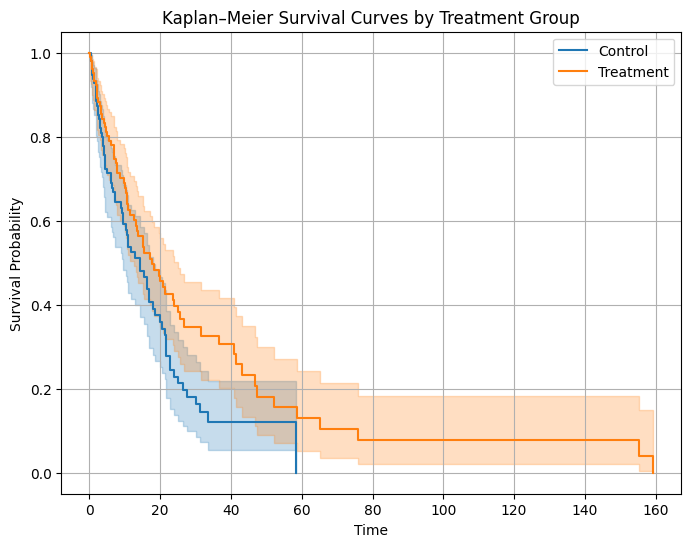

In [6]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))

for group, label in [(0, "Control"), (1, "Treatment")]:
    ix = df["treatment"] == group
    kmf.fit(
        durations=df.loc[ix, "time"],
        event_observed=df.loc[ix, "event"],
        label=label
    )
    kmf.plot_survival_function()

plt.title("Kaplan–Meier Survival Curves by Treatment Group")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


## 📈 Cox Model Coefficients — Graph Interpretation

The coefficient plot visualizes the estimated effects of covariates on the hazard
on the log scale.

- **Age:**  
  The positive coefficient indicates that increasing age is associated with an
  increased hazard, consistent with a higher risk of the event over time.

- **Treatment:**  
  The negative coefficient indicates a reduction in hazard for the treatment group
  compared to the control group, suggesting a protective treatment effect.

Coefficients to the **right of zero** increase the hazard, while coefficients to the
**left of zero** decrease the hazard. The magnitude reflects the strength of the
association.


## 4. Cox Proportional Hazards Model

The Cox proportional hazards model is a semi-parametric regression approach
used to assess the association between covariates and the hazard of an event.

Unlike Kaplan–Meier analysis, the Cox model allows adjustment for multiple
covariates simultaneously and estimates hazard ratios (HRs).

Key assumptions:
- Proportional hazards: the hazard ratio between groups is constant over time
- Independent censoring

In this section, we fit a Cox model to estimate the effect of treatment on
survival while accounting for censoring.


## 🔍 Cox Proportional Hazards Model  
### Output Interpretation

### 1️⃣ Coefficient (coef)
The coefficient represents the **log hazard ratio** associated with a one‑unit increase in the covariate.

- A **positive coefficient** indicates an increased hazard (higher risk).
- A **negative coefficient** indicates a decreased hazard (protective effect).

Because coefficients are expressed on the log scale, they are typically interpreted after exponentiation.

---

### 2️⃣ Exponentiated Coefficient (exp(coef)) — Hazard Ratio
The exponentiated coefficient corresponds to the **hazard ratio (HR)**, which is the primary quantity of interest in the Cox model.

- **HR = 1**: no association  
- **HR > 1**: increased hazard  
- **HR < 1**: reduced hazard (protective effect)

**Example:**  
If `exp(coef) = 0.70`, this indicates a **30% reduction in hazard** associated with the covariate.

---

### 3️⃣ Standard Error (se(coef))
The standard error reflects the **uncertainty of the coefficient estimate**.

- Larger standard errors indicate less precise estimates.
- Smaller standard errors indicate more stable and reliable estimates.

---

### 4️⃣ Z‑Statistic (z)
The z‑statistic is calculated as:

\[
z = \frac{\text{coef}}{\text{se(coef)}}
\]

Absolute z‑values greater than **1.96** typically indicate statistical significance at the 5% level.

---

### 5️⃣ P‑Value (p)
The p‑value tests the null hypothesis that the coefficient equals zero.

- **p < 0.05**: statistically significant association  
- **p ≥ 0.05**: no statistically significant evidence of association

---

### 6️⃣ 95% Confidence Interval for the Hazard Ratio
The confidence interval defines a range of plausible values for the hazard ratio.

- If the interval **does not include 1**, the association is statistically significant.
- If the interval **includes 1**, the association is not statistically significant.

**Example:**  
A 95% CI of **(0.50, 0.90)** indicates a statistically significant reduction in hazard.

---

### 📌 Overall Interpretation
The Cox proportional hazards model estimates hazard ratios to quantify the association between covariates and time‑to‑event outcomes.  
Hazard ratios below 1 indicate protective effects, whereas hazard ratios above 1 indicate increased risk. Statistical significance is assessed using p‑values and confidence intervals.


In [7]:
cph = CoxPHFitter()
cph.fit(df, duration_col="time", event_col="event")

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 200 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 200
number of events observed = 137
   partial log-likelihood = -586.95
         time fit was run = 2025-12-30 08:52:50 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.03      1.03      0.01            0.01            0.05                1.01                1.05
treatment -0.38      0.68      0.18           -0.73           -0.04                0.48                0.96

           cmp to     z      p  -log2(p)
covariate                               
age          0.00  3.00 <0.005      8.54
treatment    0.00 -2.18   0.03      5.10
---
Concordance = 0.61
Partial AIC = 1177.90
log-likelihood ratio test = 14.00 on 2 df
-log2(p) of ll-ratio test = 10.10

## 📊 Cox Proportional Hazards Model: Output Interpretation

### Model Overview
The Cox proportional hazards model was fitted using **200 observations**, with **137 observed events**.  
The baseline hazard was estimated using the **Breslow method**.

---

### Covariate Effects

#### Age
- **Hazard Ratio (HR):** 1.03  
- **95% CI:** (1.01, 1.05)  
- **z-statistic:** 3.00  
- **p-value:** < 0.005  

**Interpretation:**  
Age is a statistically significant predictor of the event.  
Each one-year increase in age is associated with an approximately **3% increase in hazard**, holding other variables constant.

---

#### Treatment
- **Hazard Ratio (HR):** 0.68  
- **95% CI:** (0.48, 0.96)  
- **z-statistic:** −2.18  
- **p-value:** 0.03  

**Interpretation:**  
Treatment is associated with a **statistically significant reduction in hazard**.  
Patients in the treatment group experience an approximately **32% lower risk of the event** compared to the control group.

---

### Model Performance Metrics

- **Concordance Index (C-index):** 0.61  
  - Indicates **moderate discriminative ability** of the model.
- **Partial AIC:** 177.90  
  - Used for model comparison; lower values indicate better fit.
- **Log-likelihood ratio test:** 14.00 on 2 degrees of freedom  
  - Suggests the model provides a significantly better fit than a null model.

---

### 📌 Overall Conclusion
The Cox model indicates that **age increases the hazard**, while **treatment has a protective effect**.  
Both covariates are statistically significant, and the confidence intervals do not include 1, supporting the robustness of these associations.


In [8]:
cph.hazard_ratios_


,exp(coef)
covariate,
age,1.027918
treatment,0.680545


## 🔹 Hazard Ratios (exp(coef)) — Quick Interpretation

- **Age (HR = 1.03):**  
  Each one‑year increase in age is associated with an approximately **3% increase in hazard**, indicating higher risk with increasing age.

- **Treatment (HR = 0.68):**  
  Treatment is associated with an approximately **32% reduction in hazard** compared to the control group, suggesting a **protective treatment effect**.

Overall, age increases the risk of the event, while treatment significantly reduces the hazard.


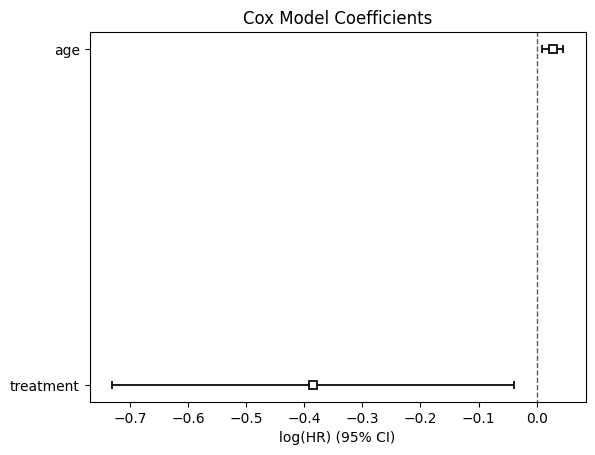

In [9]:
cph.plot()
plt.title("Cox Model Coefficients")
plt.show()
